# Construcción modelo de regresión logistica

##Integrantes

*   Juan Camilo Cataño Zuleta C.C 1001505918
*   Nataly Rodriguez Atehortua C.C 1001505918
*   Daniel Enrique López Yepes C.C 1000407016

##Información del modelo

**Tipo:** Clasificación

**Descripción:** Este algoritmo busca predecir el estado actual de la pandemia en base a una clasificación de 3 niveles. Al algoritmo se le debe pasar un vector con distintos valores y este deberá arrojar el nivel de peligro que se predice.  

## Ejecución de librerías y carga de datos

Lo primero es instalar las librerías que son necesarias para el proyecto

In [ ]:
#Librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.model_selection import learning_curve


In [ ]:
#Instalo librerías que me van a ser útiles
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

Lo siguiente es subir el aarchivo kaggle.json para poder descargar los archivos más adelante

In [ ]:
#Importamos los archivos de colab
from google.colab import files

#Subimos el .json
files.upload() #buscan el archivo kaggle.json en su ordenador

#Reubicamos el .json y descargamos el set de datos
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Ahora descargamos el set de datos

In [ ]:
#Se descarga el nuevo set de datos
!kaggle datasets download -d georgesaavedra/covid19-dataset

 55% 5.00M/9.09M [00:00<00:00, 31.0MB/s]
100% 9.09M/9.09M [00:00<00:00, 51.7MB/s]


Y lo descomprimimos

In [ ]:
#Se descomprime
!unzip /content/covid19-dataset.zip

Archive:  /content/covid19-dataset.zip
  inflating: owid-covid-data.csv     


Ahora cargo el csv

In [ ]:
dataset=pd.read_csv('owid-covid-data.csv') 

## Preprocesamiento y selección de valores

Lo primero será establecer cuáles son las columnas con las que se va a trabajar, estas serán:

*   **Nuevos casos** (new_cases): Se usará este parámetro con el fin de conocer cómo son los nuevos contagios en el país.
*   **Nuevas muertes** (new_deaths): Se usará este parámetro con el fin de conocer cómo es la tasa de mortalidad de la enfermedad.
*   **Admisiones en UCI semanales** (	weekly_icu_admissions): Se usará este parámetro con el fin de conocer cómo es la relación de pacientes en UCI.
*   **Población** (population): Se usará este parámetro con el fin de aterrizar los anteriores valores dado el contexto del país.



In [ ]:
#Ahora generamos el dataframe con la información que se necesita

#Primero elijo los datos que son obligatorios de reportar, estos serán el iso_code y la locación, es decir, el pais
cols_obligatory=["iso_code","continent","location"]

#Ahora elijo los datos con los que procesaré la información
cols_selected = ["new_cases","new_deaths","weekly_icu_admissions","population"]

#Ahora combino las columnas
cols=[]

for i in cols_obligatory:
  cols.append(i)

for i in cols_selected:
  cols.append(i)

#Ahora selecciono del dataset
myData=dataset.loc[:,cols]

#Ahora visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,NaN,NaN,39835428.0
1,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
2,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
3,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
4,AFG,Asia,Afghanistan,0.0,NaN,NaN,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,NaN,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,NaN,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,NaN,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,NaN,15092171.0


Como se observa, falta información, por lo cual esta será llenada por ceros, pues se asumirá que ese día el registro no pudo ser tomado o aún no estaba siendo rastreado.

In [ ]:
#Relleno la información de ceros
myData=myData.fillna(0)

#Ahora visualizo la información
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0
...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0


Ahora lo siguiente es la construcción de variables auxiliares de clasificación, estas variables son:

---

**Porcentaje de casos**:

Esta variable indica cuánto es el porcentaje de casos totales en relación a la población.

Matemáticamente está definida como:
```
(Casos totales / Población)*100
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 10%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población que ha sido infectado.

---

**Porcentaje de muertes**

Esta variable indica cuánto es el porcentaje de muertes totales en relación a los casos totales.

Matemáticamente está definida como:
```
(Muertes totales / Casos totales)*100
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 20%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población infectada que ha muerto.

---

**Porcentaje de nuevos casos**

Esta variable indica cuánto es el porcentaje de nuevos casos en relación a la población total.

Matemáticamente está definida como:
```
(Nuevos casos / Población)*10^5
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 20%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población que ha sido infectada. Se aplica una extrapolación debido a que se espera que sea un valor muy pequeño, es por ello que se eleva 10.000 veces.

---

**Porcentaje de UCI**

Esta variable indica cuánto es el porcentaje de pacientes en UCI en relación a los nuevos casos registrados.

Matemáticamente está definida como:
```
(Pacientes de UCI / Nuevos casos)*100
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 35%.
*   **Riesgo moderado**: Si el valor está por encima del 10%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 10%.

Este parámetro indica cuánto es el porcentaje de la población infectada recientemente y cómo es el comportamiento de los hospitalizados en UCI.

---

**Porcentaje de mortalidad**

Esta variable indica cuánto es el porcentaje de nuevas muertes en base a los nuevos contagios.

Matemáticamente está definida como:
```
(Nuevas muertes / Nuevos casos)*100
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por encima del 20%.
*   **Riesgo moderado**: Si el valor está por encima del 5%.
*   **Riesgo bajo**: Si el valor es igual o está por debajo del 5%.

Este parámetro indica cuánto es el porcentaje de la población infectada que ha muerto.

---

**Porcentaje de inmunización**

Esta variable indica cuánto es el porcentaje de personas que se han vacunado.

Matemáticamente está definida como:
```
(Nuevos vacunados / Población)*10^5
```

La clasificación de riesgo se hará bajo 5 niveles, los cuales son:


*   **Riesgo elevado**: Si el valor está por debajo del 5%.
*   **Riesgo moderado**: Si el valor está por debajo del 20%.
*   **Riesgo bajo**: Si el valor es igual o está por encima del 20%.

Este parámetro indica cuánto es el porcentaje de la población que recientemente han sido vacunados.

**Peso de los parámetros:**

El nivel de clasificación general también será basado en 5 niveles, donde a mayor nivel es mayor el riesgo. Los anteriores valores tienen cierto peso para establecer el nivel de peligro, y la ponderación de los valores más importantes tendrá una leve solapación entre sí con el objetivo de darles mayor peso. La ponderación es la siguiente:

1.   **Porcentaje de casos:** 15%
2.   **Porcentaje de muertes:** 15%
3.   **Porcentaje de nuevos casos:** 20%
4.   **Porcentaje de UCI:** 20%
5.   **Porcentaje de mortalidad:** 30%
6.   **Porcentaje de inmunización:** 10%


Ahora entonces se construye el dataset de procesamiento

In [ ]:
#Genero el dataset de procesamiento
myProcess=pd.DataFrame()

#Ahora realizo los cálculos
myProcess["Infection_percent"]=(myData["new_cases"]/myData["population"])*100000
myProcess["Mortality_percent"]=(myData["new_deaths"]/myData["new_cases"])*100
myProcess["UCI_percent"]=(myData["weekly_icu_admissions"]/myData["new_cases"])*100
#Relleno la información de la que no tengo valores
myProcess=myProcess.fillna(0)

#Observo
myProcess

,Infection_percent,Mortality_percent,UCI_percent
0,0.012552,0.000000,0.0
1,0.000000,0.000000,0.0
2,0.000000,0.000000,0.0
3,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0
...,...,...,...
166321,3.253342,0.000000,0.0
166322,4.187602,0.158228,0.0
166323,0.000000,0.000000,0.0
166324,8.189677,0.080906,0.0


Lo siguiente entonces es rankear esta información según lo que necesito

In [ ]:
#Porcentaje de contagios
mycol=pd.DataFrame()

#Obtengo la columna
mycol["Infection_percent"]=myProcess["Infection_percent"].copy()

#Ahora rankeo según el valor
mycol["Infection_percent"][mycol["Infection_percent"]<=5]=1
mycol[(mycol["Infection_percent"]<=20)&(mycol["Infection_percent"]>5)]=2
mycol[mycol["Infection_percent"]>20]=3

#Porcentaje de mortalidad

#Obtengo la columna
mycol["Mortality_percent"]=myProcess["Mortality_percent"]

#Ahora rankeo según el valor
mycol[mycol["Mortality_percent"]<=3]=1
mycol[(mycol["Mortality_percent"]<=10)&(mycol["Mortality_percent"]>3)]=2
mycol[mycol["Mortality_percent"]>10]=3

#Porcentaje de UCI

#Obtengo la columna
mycol["UCI_percent"]=myProcess["UCI_percent"]

#Ahora rankeo según el valor
mycol[mycol["UCI_percent"]<=5]=1
mycol[(mycol["UCI_percent"]<=15)&(mycol["UCI_percent"]>5)]=2
mycol[mycol["UCI_percent"]>15]=3

#Ahora visualizo de nuevo la tabla
mycol


,Infection_percent,Mortality_percent,UCI_percent
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
...,...,...,...
166321,1.0,1.0,1.0
166322,1.0,1.0,1.0
166323,1.0,1.0,1.0
166324,1.0,1.0,1.0


In [ ]:
#Visualizo la distribución de casos en general
print("Infection_percent")
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==1]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==2]))
print(len(mycol["Infection_percent"][mycol["Infection_percent"]==3]))
print("\nMortality_percent")
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==1]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==2]))
print(len(mycol["Mortality_percent"][mycol["Mortality_percent"]==3]))
print("\nUCI_percent")
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==1]))
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==2]))
print(len(mycol["UCI_percent"][mycol["UCI_percent"]==3]))

Infection_percent
163313
1728
1285

Mortality_percent
163313
1728
1285

UCI_percent
163313
1728
1285


Ahora queda generar la nueva variable, la cual será la ponderación de estos valores



In [ ]:
#Aplico la operación
mycol["Result"]=round(mycol["Infection_percent"]*0.33+mycol["Mortality_percent"]*0.33+mycol["UCI_percent"]*0.33,0)

#Ahora visualizo
mycol

,Infection_percent,Mortality_percent,UCI_percent,Result
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
166321,1.0,1.0,1.0,1.0
166322,1.0,1.0,1.0,1.0
166323,1.0,1.0,1.0,1.0
166324,1.0,1.0,1.0,1.0


In [ ]:
print("\nResult")
print(len(mycol[mycol["Result"]==1]))
print(len(mycol[mycol["Result"]==2]))
print(len(mycol[mycol["Result"]==3]))


Result
163313
1728
1285


Con la información obtenida entonces añado esta columna al dataset principal

In [ ]:
#Añado la columna
myData["clasification"]=mycol["Result"]

#Visualizo
myData

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
0,AFG,Asia,Afghanistan,5.0,0.0,0.0,39835428.0,1.0
1,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
2,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
3,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
4,AFG,Asia,Afghanistan,0.0,0.0,0.0,39835428.0,1.0
...,...,...,...,...,...,...,...,...
166321,ZWE,Africa,Zimbabwe,491.0,0.0,0.0,15092171.0,1.0
166322,ZWE,Africa,Zimbabwe,632.0,1.0,0.0,15092171.0,1.0
166323,ZWE,Africa,Zimbabwe,0.0,0.0,0.0,15092171.0,1.0
166324,ZWE,Africa,Zimbabwe,1236.0,1.0,0.0,15092171.0,1.0


## Construcción del set de entrenamiento y prueba

Debido al gran volumen de datos, el set se va a dividir en 3 partes, de la siguiente forma:

*   **Set de entrenamiento:** 70%
*   **Set de prueba:** 30%

Estos valores serán separados aleatoriamente por software, de esta forma se busca eliminar posibles problemas como el sesgo.

Voy a analizar el set de argentina

In [ ]:
#Obtengo el dataset de Argentina
mySet=myData[myData["location"]=="Argentina"]

#Observo los resultados
print("\nResult")
print(len(mySet[mySet["clasification"]==1]))
print(len(mySet[mySet["clasification"]==2]))
print(len(mySet[mySet["clasification"]==3]))


Result
795
0
0


Como se observa, Argentina no llegó a los niveles críticos, por lo cual es necesario tomar datos de países aleatorios para poder realizar el entrenamiento. Se van a tomar 500 datos de cada tipo, es decir, 500 con clasificación de 1, 500 con clasificación de 2 y 500 con clasificación de 3.

In [ ]:
#Tomo muestras aleatorias
clas_1=myData[myData["clasification"]==1].sample(500)
clas_2=myData[myData["clasification"]==2].sample(500)
clas_3=myData[myData["clasification"]==3].sample(500)

#Añado todo
mySet=pd.concat([clas_1,clas_2,clas_3])

#Lo revuelvo completamente
mySet=mySet.sample(frac = 1)

#Visualizo
mySet

,iso_code,continent,location,new_cases,new_deaths,weekly_icu_admissions,population,clasification
54351,FRA,Europe,France,2624.0,22.0,328.0,67422000.0,2.0
113481,NOR,Europe,Norway,173.0,0.0,10.0,5465629.0,2.0
141505,ESP,Europe,Spain,0.0,0.0,1037.0,46745211.0,3.0
31264,CHL,South America,Chile,7709.0,198.0,1443.0,19212362.0,3.0
19842,BES,North America,Bonaire Sint Eustatius and Saba,32.0,0.0,0.0,26445.0,1.0
...,...,...,...,...,...,...,...,...
107219,NLD,Europe,Netherlands,5759.0,24.0,321.0,17173094.0,2.0
157082,GBR,Europe,United Kingdom,44750.0,57.0,0.0,68207114.0,1.0
134510,SGP,Asia,Singapore,7.0,0.0,0.0,5453600.0,1.0
39537,CZE,Europe,Czechia,672.0,23.0,70.0,10724553.0,2.0


Entrenamos los valores

In [ ]:
#Obtengo los valores que se ingresan
X=mySet.loc[:,["new_cases","new_deaths","weekly_icu_admissions","population"]].values

#Obtengo los resultados
Y=mySet["clasification"]

In [ ]:
# Se separán los datos en train, test y validación

train_size = 0.8

# Se separan los datos de entrenamiento

X_train, X_rem, Y_train, Y_rem = train_test_split(X, Y, train_size=0.8)

# Se separán los datos de validación y de test

test_size = 0.5

X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem, Y_rem, test_size=0.5)

print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)
print(X_test.shape) 
print(Y_test.shape)

(1200, 4)
(1200,)
(150, 4)
(150,)
(150, 4)
(150,)


In [ ]:
#Verifico las formas
print(X.shape)
print(Y.shape)

(1500, 4)
(1500,)


In [ ]:
#Verifico que no haya datos nulos
print(np.any(np.isnan(X)),np.any(np.isnan(Y)))

False False


In [ ]:
#Verifico que todos los datos sean finitos
print(np.all(np.isfinite(X)),np.all(np.isfinite(Y)))

True True


## Regresión lógistica

In [ ]:

#Creamos el modelo de regresión logistca
logistic_regressionP_clf = LogisticRegression(random_state=0, max_iter=10000)
logistic_regressionP_clf.fit(X_train, Y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
#Probamos el score entre X_test y Y_test
logistic_regressionP_clf.score(X_test, Y_test)

0.34

In [ ]:
#Probamos el score entre X_valid y Y_valid
logistic_regressionP_clf.score(X_valid, Y_valid)

0.36666666666666664

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

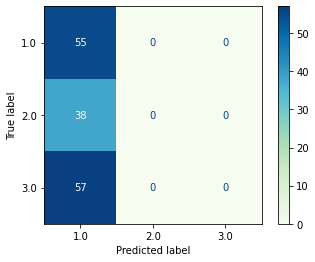

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

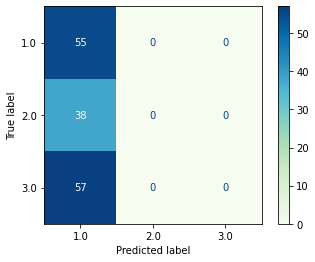

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


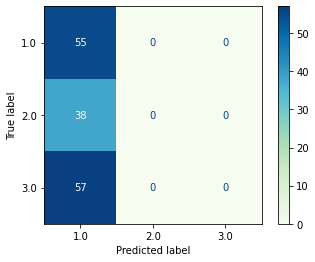

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         1.0       0.39      0.82      0.53        55
         2.0       0.51      0.47      0.49        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.42       150
   macro avg       0.30      0.43      0.34       150
weighted avg       0.27      0.42      0.32       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


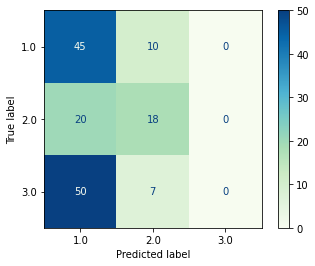

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



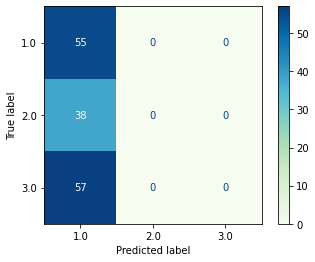

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

         1.0       0.38      0.82      0.52        55
         2.0       0.53      0.45      0.49        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.41       150
   macro avg       0.30      0.42      0.34       150
weighted avg       0.27      0.41      0.31       150



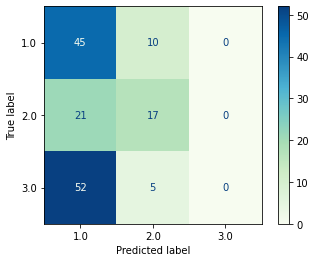

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



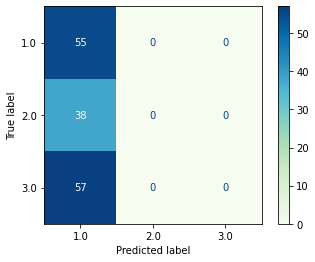

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


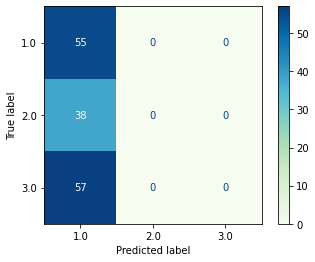

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



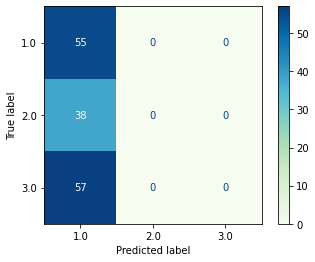

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

              precision    recall  f1-score   support

         1.0       0.37      1.00      0.54        55
         2.0       0.00      0.00      0.00        38
         3.0       0.00      0.00      0.00        57

    accuracy                           0.37       150
   macro avg       0.12      0.33      0.18       150
weighted avg       0.13      0.37      0.20       150



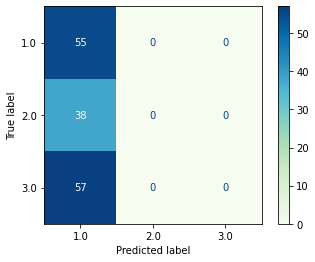

El promedio en validación es de 0.3767


In [ ]:
# Proceso de k-folds
k_folds = KFold(10, random_state=1, shuffle = True)
X_ = np.concatenate((X_train, X_test))
Y_ = np.concatenate((Y_train, Y_test))
scores_valid = np.zeros(10)
for pos, (train, test) in enumerate(k_folds.split( X_, Y_)): 

  logistic_regressionP_clf.fit(X_[train], Y_[train])
  y_pred = logistic_regressionP_clf.predict(X_[test])
  scores_valid[pos] = logistic_regressionP_clf.score(X_valid,Y_valid)
  plot_confusion_matrix(logistic_regressionP_clf, X_valid, Y_valid, cmap='GnBu')
  y_pred_valid = logistic_regressionP_clf.predict(X_valid)
  print(classification_report(Y_valid, y_pred_valid))
  plt.show() 

print(f'El promedio en validación es de {round(scores_valid.mean(),4)}')

Como se pudo notar, tenemos en promodeio de validacion un 0.3147, lo que nos queire decir que el modelo no se esta entrenando correctamente

## Curva de aprendizaje

In [ ]:
#Curva de aprendizaje 
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Genera 3 graficas: La curva de prueba y la curva de aprendizaje, los datos 
    de entrenamiento vs la curva de tiempos de ajuste, la curva de tiempos de 
    ajuste frente a la puntuación.

    Parameters
    ----------
    estimator : instancia de estimador. Una instancia de estimador que implementa los métodos `fit` y `predict` 
    que se clonará para cada validación.

    title : str

    X : array-like de tamaño (n_samples, n_features)
        vector de entrenamiento, donde``n_samples``es el numero de muestras y ``n_features`` es 
        el número de caracteristicas.

    y : array-like de tamaño (n_samples) o (n_samples, n_features)
        Objetivo relativo a ``X`` para la clasificación o la regresión;

    axes : array-like de tamañoe (3,), default=None
        Se implementa para la grafica de la curva.

    ylim : tuple de tamaño (2,), default=None

    cv : int, generador de validación cruzada o un iterable, por defecto=None
        Determina la estrategia de división de la validación cruzada.
        Las entradas posibles para cv son:

          - None, para utilizar la validación cruzada de 5 pliegues por defecto,
          - Entero, para especificar el número de pliegues.
          - Un iterable que produce divisiones (tren, prueba) como matrices de índices.

    n_jobs : int o None, por defecto=None
        Número de trabajos a ejecutar en paralelo.

    scoring : str or callable, default=None

    train_sizes : tipo array de forma (n_ticks,)
        Números relativos o absolutos de muestras de entrenamiento que se utilizarán para
        generar la curva de aprendizaje. Si el ``dtype`` es float, se considera
        como una fracción del tamaño máximo del conjunto de entrenamiento (que es
        (determinado por el método de validación seleccionado), es decir, tiene que estar dentro de
        (0, 1]. En caso contrario, se interpreta como el tamaño absoluto de los conjuntos de
        de los conjuntos de entrenamiento. Tenga en cuenta que, para la clasificación, el número de muestras 
        suele ser lo suficientemente grande como para contener al menos una muestra de cada clase.
        (por defecto: np.linspace(0.1, 1.0, 5))
    """
    #Se estable los axes
    if axes is None:
        _, axes = plt.subplots(1, figsize=(10, 10))


    axes.set_title(title)
    #Se establece y lim 
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    #Se genera la curva de aprendizaje 
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Grafico de la curva de aprendizaje
    axes.grid()
    axes.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes.plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes.legend(loc="best")

    #Se retorna el grafico de la curva de aprendizaje
    return plt

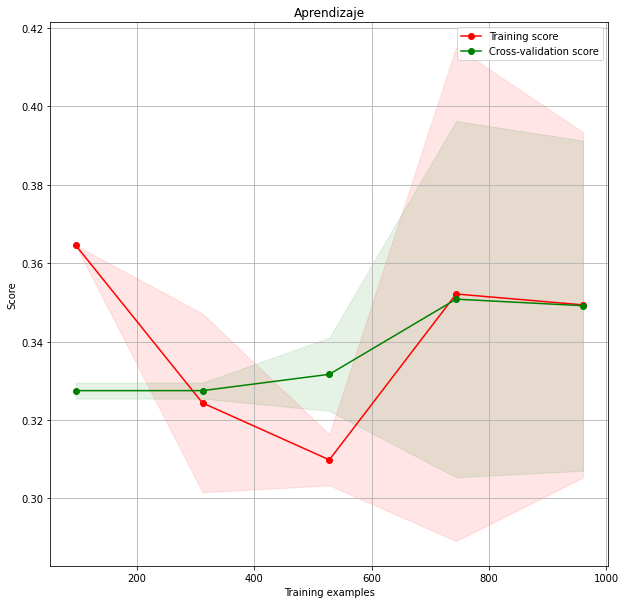

In [ ]:
#Se genera la curva de aprendizaje 
plot_learning_curve(estimator=logistic_regressionP_clf ,
                    X=X_train,
                    y=Y_train,
                    title='Aprendizaje')
plt.show()